Step 1: Import library

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import ttest_ind, levene, chi2_contingency
from semopy import Model, calc_stats
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.stats import skew, kurtosis

Step 2: Preprocess data

Step 2.1: Read data and drop some unused columns

In [2]:
df = pd.read_csv("household.csv")

In [3]:
df = df.drop([
    'main',
    'description',
    'temp_min',
    'temp_max'
], axis=1)

In [26]:
# Read data csv
df = pd.read_csv("household.csv")
df = df.drop([
    'main',
    'description',
    'temp_min',
    'temp_max',
    'temp_t+1',
    'feels_like_t+1',
], axis=1)

Step 2.2: Load data and resample to hour

In [4]:

# change date column into datetime 
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).sort_values('date')

# merge data by hour (mean)
df_hour = (
    df.set_index('date')
      .resample('H')
      .mean(numeric_only=True)  
      .reset_index()
)

print("The initial columns:", len(df), "→ After merging followed by hour:", len(df_hour))
df_hour

The initial columns: 605260 → After merging followed by hour: 10234


,date,active_power,current,voltage,reactive_power,apparent_power,power_factor,temp,feels_like,pressure,humidity,speed,deg,temp_t+1,feels_like_t+1
0,2022-11-05 14:00:00,248.780000,2.301455,122.312727,127.066364,281.159455,0.885213,24.246364,23.728182,1011.909091,38.436364,0.081818,8.000000,29.606000,27.912000
1,2022-11-05 15:00:00,202.663333,2.062333,122.410000,136.873500,252.208500,0.802048,24.302000,23.765333,1010.666667,37.366667,2.912167,333.900000,29.721333,27.978333
2,2022-11-05 16:00:00,198.863333,1.933833,122.725000,116.217833,234.804833,0.811255,24.174000,23.605833,1011.416667,36.666667,2.322667,326.750000,29.847667,28.139333
3,2022-11-05 17:00:00,390.181667,3.656500,122.185000,202.436167,445.381500,0.846390,23.485667,22.830667,1010.600000,36.083333,2.455000,302.833333,27.960167,26.480667
4,2022-11-05 18:00:00,443.036667,3.839500,121.908333,143.828000,467.515167,0.946220,21.693667,20.933333,1008.816667,38.783333,2.269500,267.316667,26.836500,26.228167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10229,2024-01-05 19:00:00,329.995556,3.069556,128.915556,218.261333,395.692667,0.834627,13.546889,12.099556,1013.733333,43.733333,2.396889,287.600000,10.849136,9.539646
10230,2024-01-05 20:00:00,393.211864,3.386610,128.611864,172.850339,433.508814,0.899202,11.364576,9.752203,1012.559322,45.779661,0.279322,35.898305,8.580207,8.332793
10231,2024-01-05 21:00:00,233.649153,2.048814,129.681356,123.606949,265.509492,0.878768,10.550508,8.994915,1014.288136,51.067797,0.151525,16.677966,5.891412,5.837382
10232,2024-01-05 22:00:00,374.113333,3.283167,128.510000,191.756333,421.607833,0.878000,9.260333,8.541500,1012.100000,50.766667,1.621000,151.700000,13.182741,11.559438


Step 2.3: Prepare some data columns

In [5]:


df_hour['weekday'] = df_hour['date'].dt.weekday
df_hour['is_weekend'] = df_hour['weekday'].isin([5,6]).astype(int)

# Lag features
df_hour['ap_lag_1h'] = df_hour['active_power'].shift(1)
df_hour['ap_lag_24h'] = df_hour['active_power'].shift(24)
df_hour['ap_roll_24h'] = df_hour['active_power'].rolling(24, min_periods=1).mean()
df_hour.dropna(inplace=True)

Step 2.4: View data

In [6]:
df_hour.head(1)

,date,active_power,current,voltage,reactive_power,apparent_power,power_factor,temp,feels_like,pressure,humidity,speed,deg,temp_t+1,feels_like_t+1,weekday,is_weekend,ap_lag_1h,ap_lag_24h,ap_roll_24h
24,2022-11-06 14:00:00,163.376667,1.701333,122.801667,125.215667,208.594833,0.762977,28.653167,27.250167,1013.916667,21.083333,3.781167,358.783333,24.246333,23.7295,6,1,224.355,248.78,273.720891


Step 3. Implement models

Step 3.1: Descriptive statistic(Thống kê mô tả, làm để biết dữ liệu có sạch không)

=== (Descriptive Statistics) ===


,count,mean,std,min,Q1,median,Q3,max,CV(%),Skewness,Kurtosis
active_power,10112.0,286.186,140.941,47.870,184.793,262.268,358.115,969.083,49.248,1.036,1.228
current,10112.0,2.589,1.161,0.574,1.756,2.376,3.162,8.362,44.861,1.117,1.511
voltage,10112.0,125.414,4.355,110.730,122.574,124.378,129.545,135.190,3.473,0.338,-0.769
reactive_power,10112.0,132.594,42.469,37.180,100.749,125.981,161.137,355.570,32.030,0.584,0.020
apparent_power,10112.0,322.017,138.861,74.060,221.098,298.000,394.038,1036.680,43.122,1.024,1.205
power_factor,10112.0,0.854,0.089,0.560,0.791,0.878,0.925,0.996,10.417,-0.648,-0.555
temp,10112.0,19.527,6.537,-4.000,14.809,19.476,24.289,38.065,33.480,-0.063,-0.339
feels_like,10112.0,18.715,6.648,-4.679,13.868,18.835,23.815,35.462,35.523,-0.177,-0.466
pressure,10112.0,1015.240,5.761,999.000,1011.000,1014.975,1019.150,1032.900,0.567,0.188,-0.391
speed,10112.0,2.625,1.947,0.000,1.090,2.265,3.873,10.290,74.180,0.821,0.066


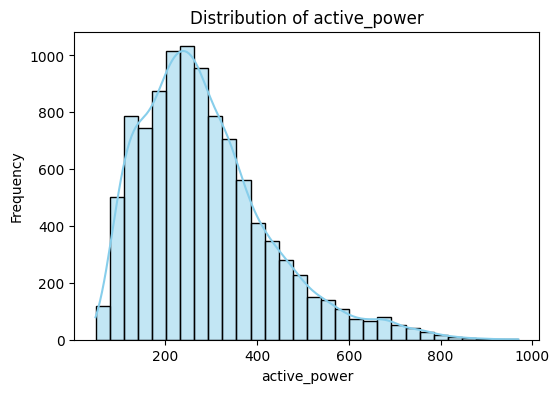

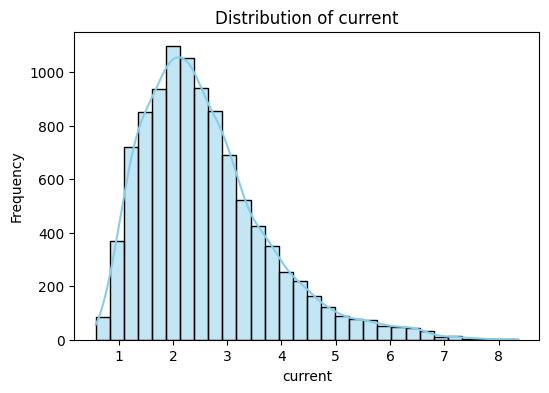

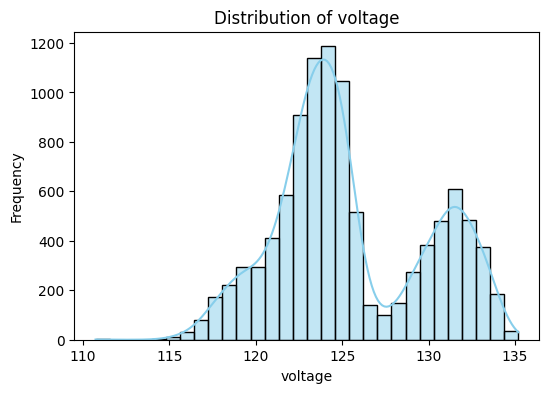

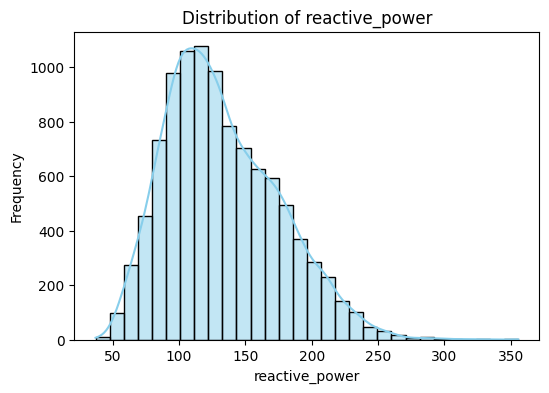

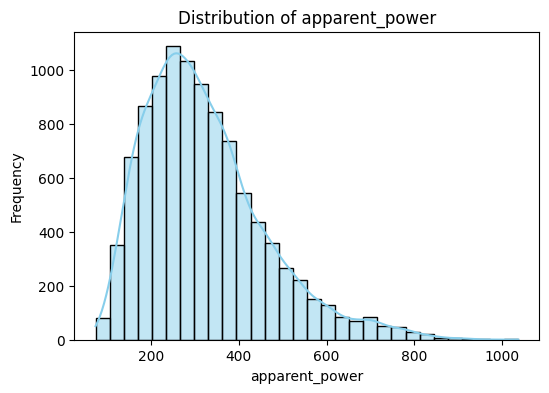

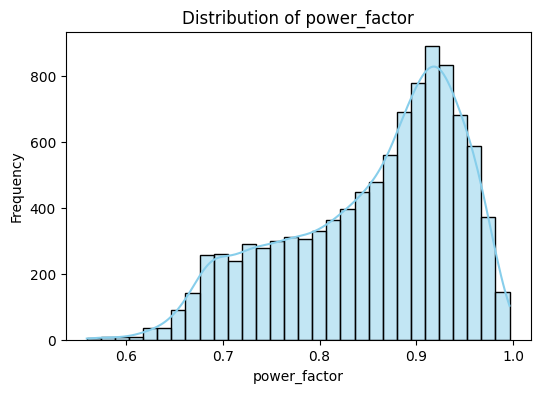

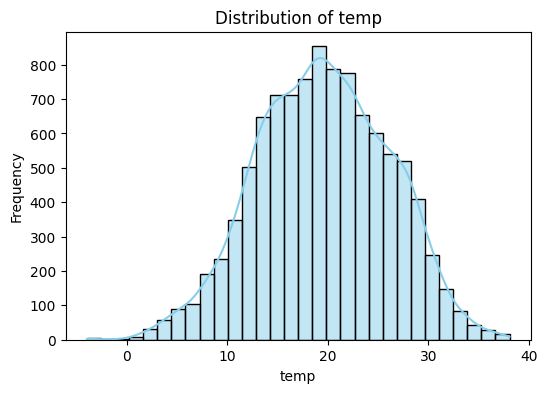

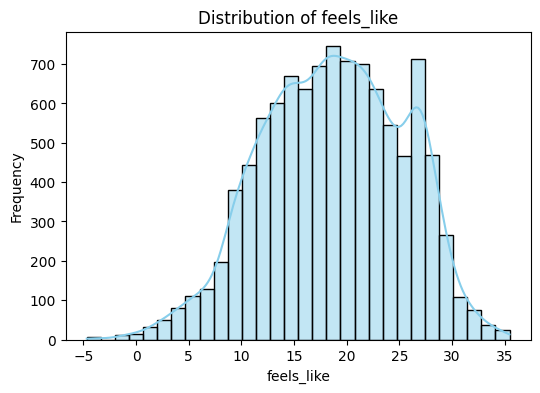

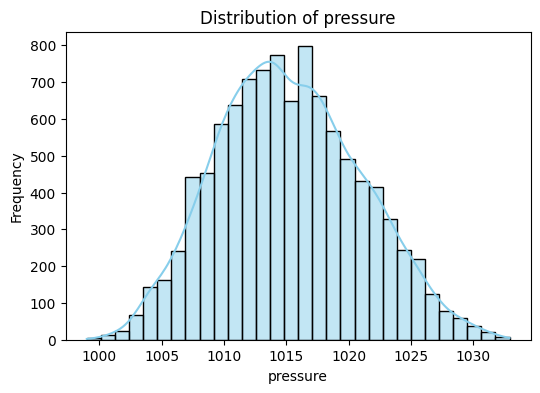

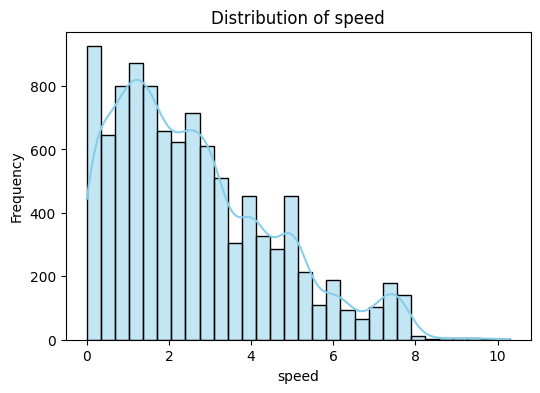

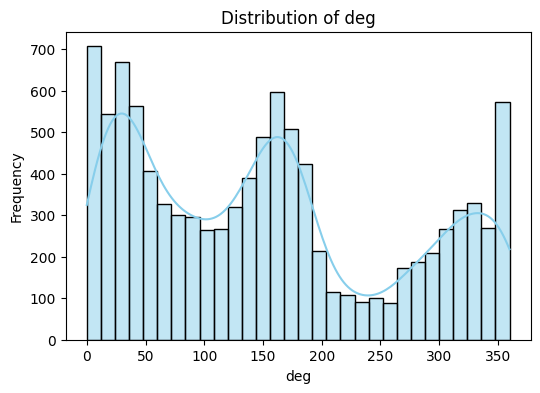

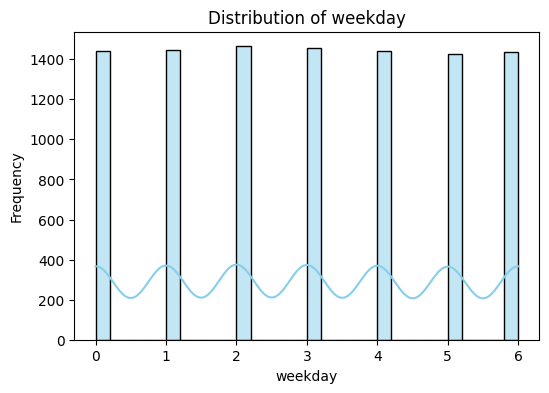

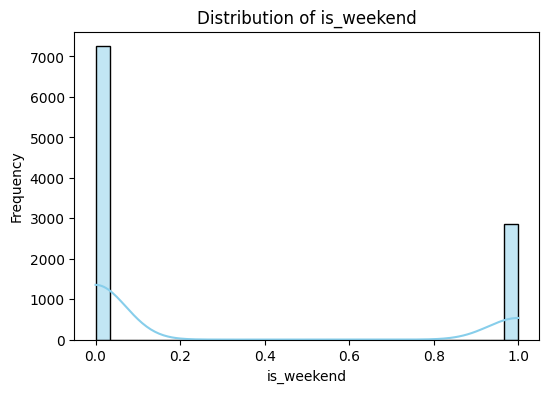

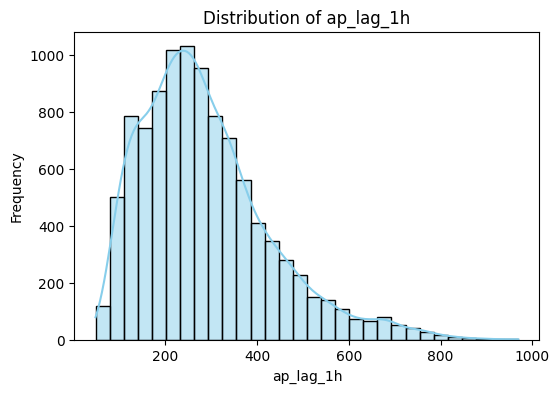

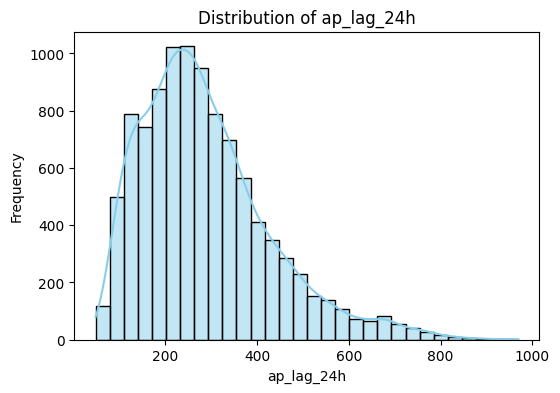

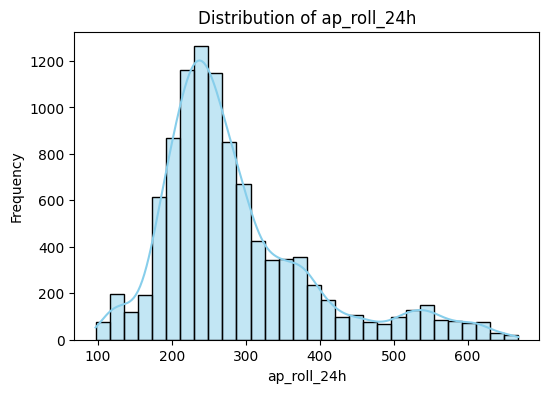

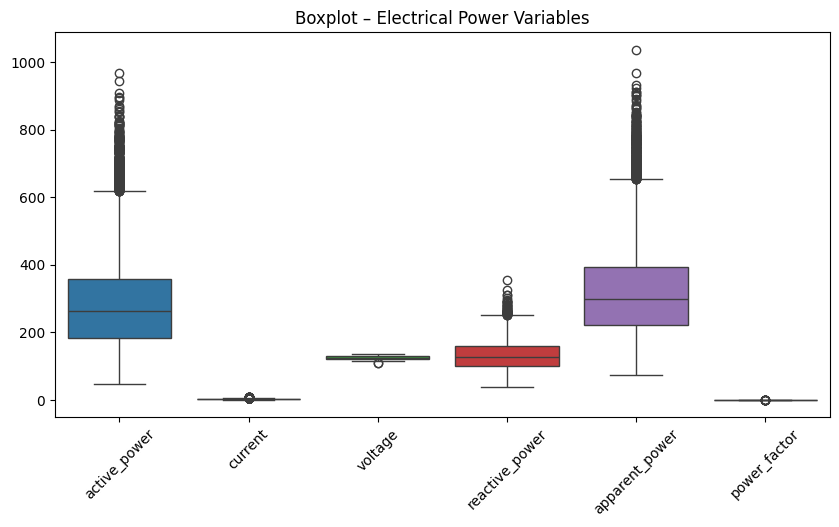

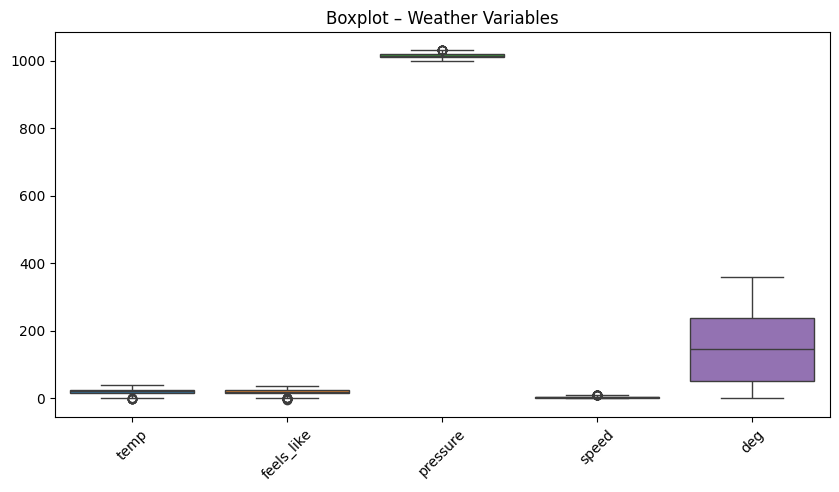

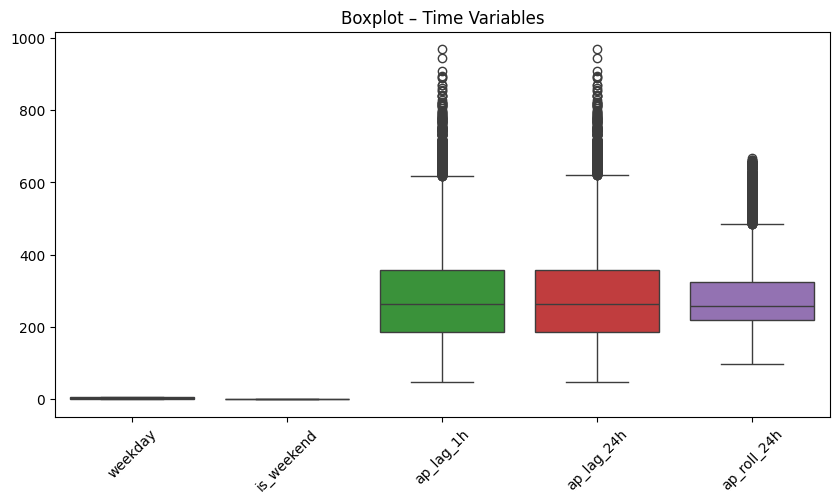

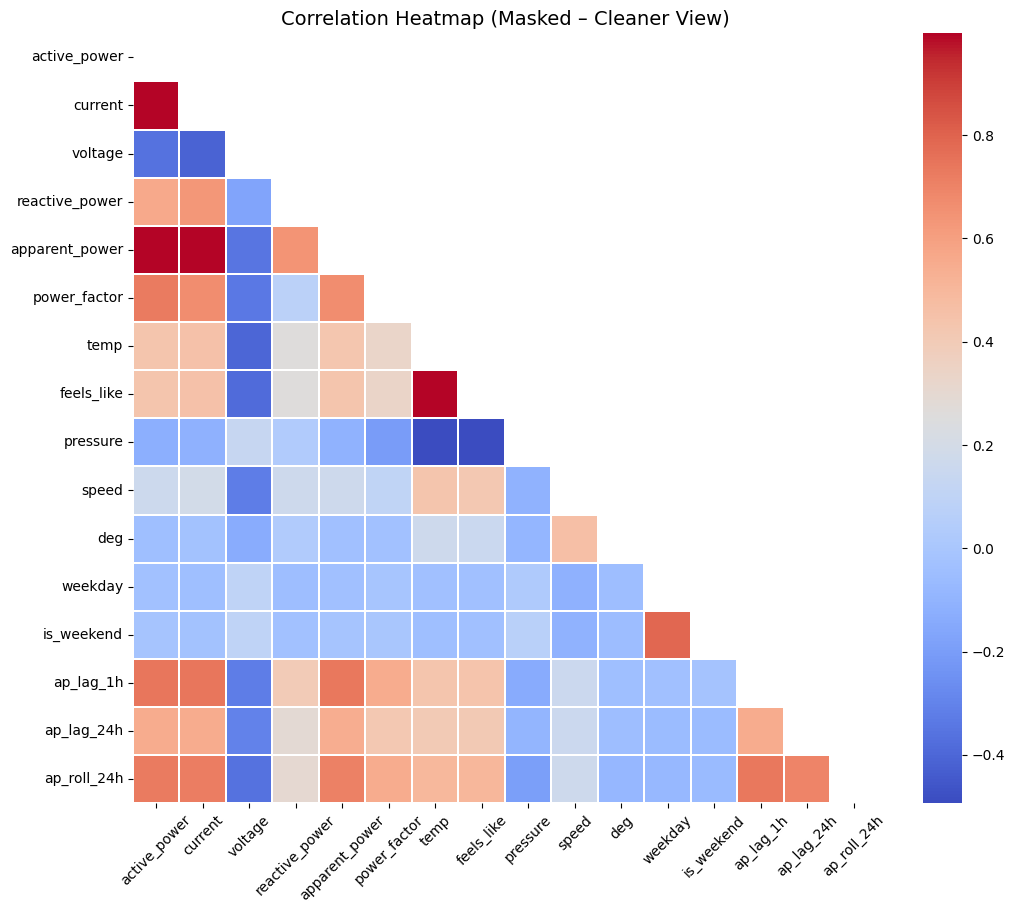

In [7]:

# Choose numeric columns for analysis
num_cols = ['active_power', 'current', 'voltage', 'reactive_power'
            ,'apparent_power', 'power_factor', 'temp', 'feels_like'
            ,'feels_life', 'pressure', 'hudmidity', 'speed'
            ,'deg', 'weekday', 'is_weekend', 'ap_lag_1h', 'ap_lag_24h', 'ap_roll_24h']
num_cols = [c for c in num_cols if c in df_hour.columns]

# Create an empty DataFrame to hold the statistics
stats = pd.DataFrame(index=num_cols, columns=[
    'count', 'mean', 'std', 'min', 'Q1', 'median', 'Q3', 'max',
    'CV(%)', 'Skewness', 'Kurtosis'
])

for col in num_cols:
    data = df_hour[col].dropna()
    stats.loc[col, 'count'] = data.count()
    stats.loc[col, 'mean'] = data.mean()
    stats.loc[col, 'std'] = data.std()
    stats.loc[col, 'min'] = data.min()
    stats.loc[col, 'Q1'] = data.quantile(0.25)
    stats.loc[col, 'median'] = data.median()
    stats.loc[col, 'Q3'] = data.quantile(0.75)
    stats.loc[col, 'max'] = data.max()
    stats.loc[col, 'CV(%)'] = (data.std() / data.mean()) * 100
    stats.loc[col, 'Skewness'] = skew(data)
    stats.loc[col, 'Kurtosis'] = kurtosis(data)

# Round the statistics for better readability
stats = stats.astype(float).round(3)

# Show the descriptive statistics table
print("=== (Descriptive Statistics) ===")
display(stats)

# Data Visualization
# Histogram + KDE
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df_hour[col], bins=30, kde=True, color='skyblue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Boxplot

#Power variables
power_vars = ['active_power','current','voltage','reactive_power',
              'apparent_power','power_factor']

plt.figure(figsize=(10,5))
sns.boxplot(data=df_hour[power_vars])
plt.title("Boxplot – Electrical Power Variables")
plt.xticks(rotation=45)
plt.show()

# Weather variables
weather_vars = ['temp','feels_like','pressure','speed','deg']

plt.figure(figsize=(10,5))
sns.boxplot(data=df_hour[weather_vars])
plt.title("Boxplot – Weather Variables")
plt.xticks(rotation=45)
plt.show()

#  Time-derived variables
time_vars = ['weekday','is_weekend','ap_lag_1h','ap_lag_24h','ap_roll_24h']

plt.figure(figsize=(10,5))
sns.boxplot(data=df_hour[time_vars])
plt.title("Boxplot – Time Variables")
plt.xticks(rotation=45)
plt.show()



# Correlation heatmap
corr = df_hour[num_cols].corr()

plt.figure(figsize=(12,10))

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, 
            mask=mask, 
            cmap='coolwarm', 
            linewidths=0.3,
            annot=False)

plt.title("Correlation Heatmap (Masked – Cleaner View)", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()



Step 3.2: Inferential statistic(thống kê suy luận, để kiểm đinhn giả thuyết, so sánh nhóm) T-test, anova, correlation test(pearson)

=== Pearson Correlation: Weather vs Active Power ===


,Variable,Correlation (r),p-value
0,temp,0.433,0.0
1,feels_like,0.437,0.0
2,humidity,-0.139,0.0
3,speed,0.161,0.0
4,pressure,-0.124,0.0


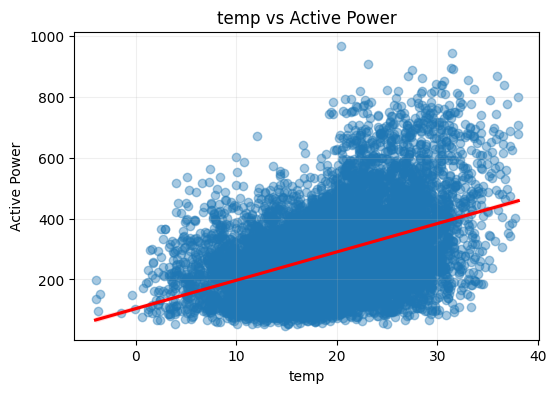

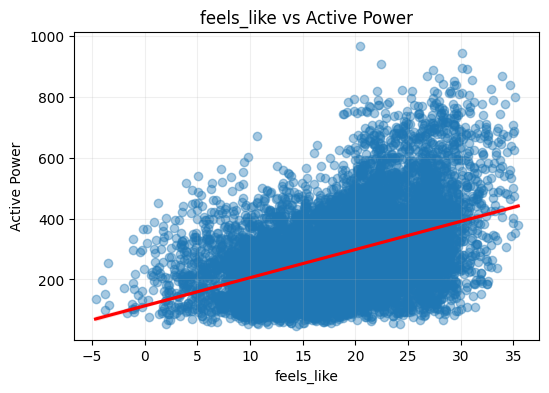

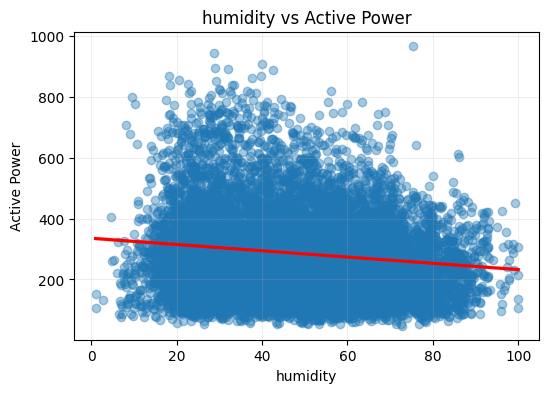

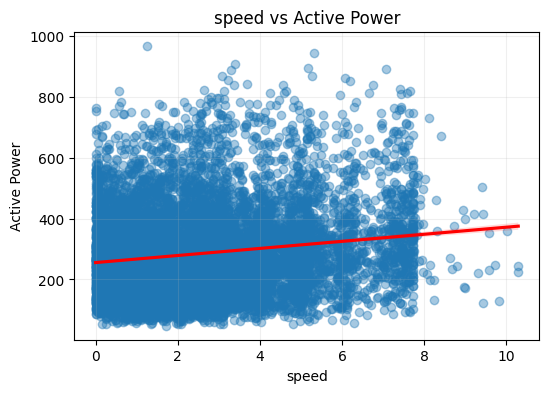

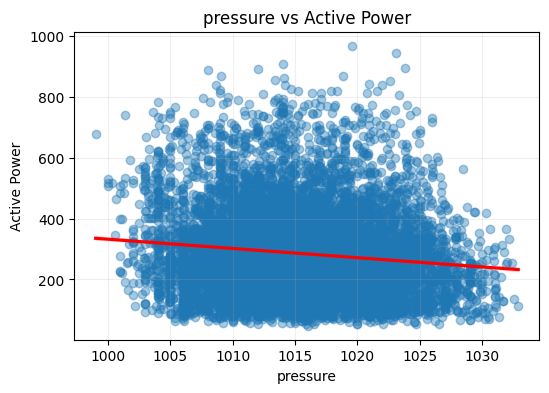


=== T-test: Active Power (Weekend vs Weekday) ===
T-statistic = -1.259
P-value     = 0.20801
→ Kết luận: Không có sự khác biệt đáng kể.

=== ANOVA: Active Power theo ngày trong tuần (0–6) ===
F-statistic = 8.092
P-value     = 0.00000
→ Kết luận: Mức tiêu thụ điện khác nhau theo các ngày trong tuần.


In [8]:
from scipy.stats import pearsonr, ttest_ind, f_oneway
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# ================================
# 1. PEARSON CORRELATION (WEATHER → ACTIVE POWER)
# ================================

weather_vars = ['temp', 'feels_like', 'humidity', 'speed', 'pressure']
results = []

for col in weather_vars:
    r, p = pearsonr(df_hour['active_power'], df_hour[col])
    results.append([col, round(r, 3), round(p, 5)])

corr_df = pd.DataFrame(results, columns=['Variable', 'Correlation (r)', 'p-value'])

print("=== Pearson Correlation: Weather vs Active Power ===")
display(corr_df)


# ================================
# 2. SCATTERPLOTS WITH REGRESSION LINE
# ================================

for col in weather_vars:
    plt.figure(figsize=(6, 4))
    sns.regplot(
        x=df_hour[col], 
        y=df_hour['active_power'], 
        scatter_kws={'alpha': 0.4}, 
        line_kws={'color': 'red'}
    )
    plt.title(f"{col} vs Active Power")
    plt.xlabel(col)
    plt.ylabel("Active Power")
    plt.grid(alpha=0.2)
    plt.show()


# ================================
# 3. T-TEST: WEEKDAY vs WEEKEND
# ================================

power_weekend = df_hour[df_hour['is_weekend'] == 1]['active_power']
power_weekday = df_hour[df_hour['is_weekend'] == 0]['active_power']

t_stat, p_val = ttest_ind(power_weekend, power_weekday, equal_var=False)

print("\n=== T-test: Active Power (Weekend vs Weekday) ===")
print(f"T-statistic = {t_stat:.3f}")
print(f"P-value     = {p_val:.5f}")

if p_val < 0.05:
    print("→ Kết luận: Có sự khác biệt có ý nghĩa thống kê giữa ngày cuối tuần và ngày thường.")
else:
    print("→ Kết luận: Không có sự khác biệt đáng kể.")


# ================================
# 4. ANOVA: ACTIVE POWER theo 7 ngày trong tuần
# ================================

groups = [df_hour[df_hour['weekday'] == i]['active_power'] for i in range(7)]

f_stat, p_val = f_oneway(*groups)

print("\n=== ANOVA: Active Power theo ngày trong tuần (0–6) ===")
print(f"F-statistic = {f_stat:.3f}")
print(f"P-value     = {p_val:.5f}")

if p_val < 0.05:
    print("→ Kết luận: Mức tiêu thụ điện khác nhau theo các ngày trong tuần.")
else:
    print("→ Kết luận: Không có sự khác biệt đáng kể giữa các ngày.")


Step 3.3: Regression analysis(OLS) , là tìm mối quan hệ định lượng giữa biến X và Y, linear regression, logistic regression.

A – SIMPLE LINEAR REGRESSION

In [9]:
import statsmodels.api as sm

weather_vars = ['temp', 'feels_like', 'humidity', 'pressure', 'speed']

for col in weather_vars:
    X = df_hour[[col]]
    y = df_hour['active_power']

    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    print("\n==============================")
    print(f"Simple Regression: active_power ~ {col}")
    print(model.summary())
    print("==============================\n")




Simple Regression: active_power ~ temp
                            OLS Regression Results                            
Dep. Variable:           active_power   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     2328.
Date:                Fri, 14 Nov 2025   Prob (F-statistic):               0.00
Time:                        15:07:55   Log-Likelihood:                -63338.
No. Observations:               10112   AIC:                         1.267e+05
Df Residuals:                   10110   BIC:                         1.267e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

In [10]:
import statsmodels.api as sm

features = ['temp', 'feels_like', 'humidity', 'pressure', 'speed']

X = df_hour[features]
y = df_hour['active_power']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print("=== MULTIPLE LINEAR REGRESSION (Weather → Active Power) ===")
print(model.summary())


=== MULTIPLE LINEAR REGRESSION (Weather → Active Power) ===
                            OLS Regression Results                            
Dep. Variable:           active_power   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     556.1
Date:                Fri, 14 Nov 2025   Prob (F-statistic):               0.00
Time:                        15:07:59   Log-Likelihood:                -63157.
No. Observations:               10112   AIC:                         1.263e+05
Df Residuals:                   10106   BIC:                         1.264e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

Step 3.4: SEM(Path analysis) Mô hình hóa cấu trúc nhân quả giữa các biến tiềm ẩn + quan sát.

In [11]:
from semopy import Model, calc_stats
from sklearn.preprocessing import StandardScaler
import pandas as pd

# =======================
# 1. STANDARDIZE DATA
# =======================
sem_vars = ['temp', 'feels_like', 'humidity', 'pressure', 'speed', 'active_power']

scaler = StandardScaler()
df_sem = pd.DataFrame(scaler.fit_transform(df_hour[sem_vars]), columns=sem_vars)

# =======================
# 2. SEM MODEL
# =======================
model_desc = """
Weather =~ temp + feels_like + humidity + pressure + speed
active_power ~ Weather
"""

model = Model(model_desc)

# =======================
# 3. FIT MODEL
# =======================
res = model.fit(df_sem)
print("=== SEM Fit Summary ===")
print(res)

# =======================
# 4. STANDARDIZED ESTIMATES
# =======================
print("\n=== STANDARDIZED ESTIMATES ===")
est_std = model.inspect(std_est=True)
print(est_std)

# =======================
# 5. MODEL FIT STATISTICS
# =======================
fit_stats = calc_stats(model)

print("\n=== SEM FIT STATISTICS ===")
metrics = ['chi2', 'DoF', 'p-value', 'rmsea', 'cfi', 'tli', 'srmr']

for m in metrics:
    if m in fit_stats.columns:
        print(f"{m}: {fit_stats[m].values[0]}")
    else:
        print(f"{m}: (not available)")

# =======================
# 6. R-SQUARED
# =======================
print("\n=== R-SQUARED ===")
try:
    r2 = model.inspect_statistics()['r2']
    print(r2)
except:
    if 'r2' in fit_stats.columns:
        print(fit_stats[['r2']])
    else:
        print("R-squared not available in this semopy version.")


=== SEM Fit Summary ===
Name of objective: MLW
Optimization method: SLSQP
Optimization successful.
Optimization terminated successfully
Objective value: 1.583
Number of iterations: 35
Params: 1.003 -0.553 -0.498 0.429 0.438 0.986 0.810 0.020 0.697 0.754 0.817 0.020

=== STANDARDIZED ESTIMATES ===
            lval  op          rval  Estimate  Est. Std  Std. Err     z-value  \
0           temp   ~       Weather  1.000000  0.990142         -           -   
1     feels_like   ~       Weather  1.002707  0.990164  0.002694  372.225722   
2       humidity   ~       Weather -0.552554 -0.549323  0.008451  -65.381498   
3       pressure   ~       Weather -0.497596 -0.494552  0.008779  -56.677677   
4          speed   ~       Weather  0.428905  0.426228  0.009126   46.999703   
5   active_power   ~       Weather  0.437761  0.434940  0.009087   48.174069   
6        Weather  ~~       Weather  0.986174  1.000000  0.014257   69.170724   
7   active_power  ~~  active_power  0.810024  0.810827  0.0114

Step 3.5: Arimax

In [ ]:
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("\n=== OPTIMIZED ARIMAX GRID SEARCH ===")

# Exogenous variables
exog_vars = [
    v for v in ['temp','humidity','pressure','speed',
                'ap_lag_1h','ap_lag_24h','ap_roll_24h']
    if v in df_hour.columns
]
exog = df_hour[exog_vars]

# Train/test split
split = int(len(df_hour) * 0.8)
y_train = df_hour['active_power'][:split]
y_test  = df_hour['active_power'][split:]
exog_train = exog[:split]
exog_test  = exog[split:]

# Grid search for ARIMA parameters
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
orders = list(product(p, d, q))

results = []

for order in orders:
    try:
        model = SARIMAX(
            y_train,
            exog=exog_train,
            order=order,
            seasonal_order=(1, 0, 0, 24),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        res = model.fit(disp=False)
        
        pred = res.get_forecast(steps=len(y_test), exog=exog_test)
        y_pred = pred.predicted_mean
        
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        results.append((order, res.aic, mae, rmse))
        print(f"ARIMAX{order} → AIC={res.aic:.2f}, MAE={mae:.4f}, RMSE={rmse:.4f}")
    
    except Exception as e:
        print(f"Skip ARIMAX{order} ({e})")
        continue

# Select best model
if len(results) > 0:
    results_sorted = sorted(results, key=lambda x: (x[1], x[2]))
    best_order, best_aic, best_mae, best_rmse = results_sorted[0]
    
    print(f"\nBest ARIMAX{best_order} → AIC={best_aic:.2f}, MAE={best_mae:.4f}, RMSE={best_rmse:.4f}")
    
    best_model = SARIMAX(
        y_train,
        exog=exog_train,
        order=best_order,
        seasonal_order=(1, 0, 0, 24),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    best_res = best_model.fit(disp=False)
    best_pred = best_res.get_forecast(steps=len(y_test), exog=exog_test)
    y_best_pred = best_pred.predicted_mean
    conf_int = best_pred.conf_int()

    # Forecast plot
    plt.figure(figsize=(12, 5))
    plt.plot(y_test.index, y_test.values, label='Actual', color='black')
    plt.plot(y_test.index, y_best_pred.values, label=f'ARIMAX{best_order}', color='blue')
    plt.fill_between(
        y_test.index,
        conf_int.iloc[:, 0],
        conf_int.iloc[:, 1],
        color='lightblue',
        alpha=0.4,
        label='Confidence Interval'
    )
    plt.legend()
    plt.title(f'Best ARIMAX{best_order} Forecast with Daily Seasonality')
    plt.show()

    # Residual diagnostics
    residuals = best_res.resid

    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True)
    plt.title("Residual Distribution")
    plt.show()

    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_test, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title("Residuals vs Actual")
    plt.show()

else:
    print("No ARIMAX model fitted successfully.")



=== OPTIMIZED ARIMAX GRID SEARCH ===
ARIMAX(0, 0, 0) → AIC=95189.26, MAE=57.3722, RMSE=76.1979
ARIMAX(0, 0, 1) → AIC=95150.18, MAE=60.2730, RMSE=78.7422
ARIMAX(0, 0, 2) → AIC=94742.60, MAE=85.8737, RMSE=110.6863
ARIMAX(0, 1, 0) → AIC=94991.51, MAE=379.4828, RMSE=490.7156
ARIMAX(0, 1, 1) → AIC=91917.85, MAE=820.0033, RMSE=1039.7103
ARIMAX(0, 1, 2) → AIC=91838.41, MAE=943.1962, RMSE=1210.2402
ARIMAX(1, 0, 0) → AIC=94798.41, MAE=74.0831, RMSE=95.3135
ARIMAX(1, 0, 1) → AIC=94392.86, MAE=101.4584, RMSE=132.1754
ARIMAX(1, 0, 2) → AIC=94412.19, MAE=102.5510, RMSE=133.4988
ARIMAX(1, 1, 0) → AIC=93384.37, MAE=892.9479, RMSE=1143.6898
ARIMAX(1, 1, 1) → AIC=91720.76, MAE=1039.3254, RMSE=1331.9114
ARIMAX(1, 1, 2) → AIC=92863.07, MAE=535.0143, RMSE=675.9761
ARIMAX(2, 0, 0) → AIC=94621.02, MAE=81.9135, RMSE=105.7745
ARIMAX(2, 0, 1) → AIC=94786.66, MAE=74.5733, RMSE=96.1636
ARIMAX(2, 0, 2) → AIC=95174.58, MAE=57.4446, RMSE=76.2594
ARIMAX(2, 1, 0) → AIC=92541.04, MAE=967.3055, RMSE=1239.8705
ARIMAX(2

Step 3.6: Machine learning-Random forest

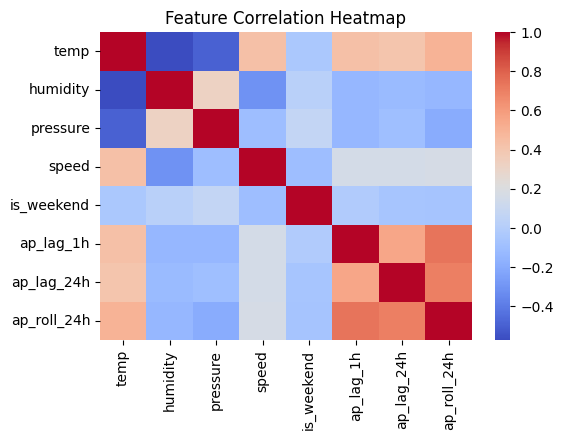

Random Forest CV → MAE=77.1916, RMSE=99.6058, R²=0.2957


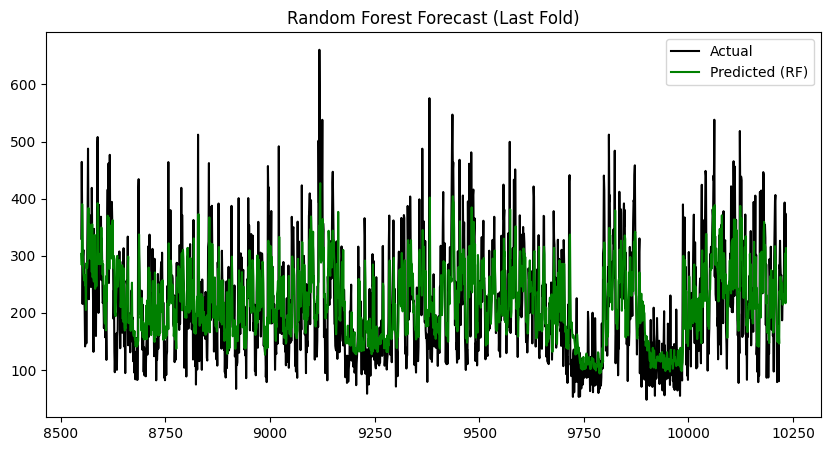

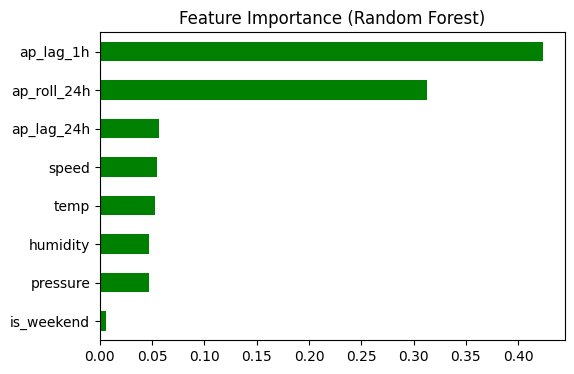

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ========================
# 1. Chuẩn bị dữ liệu
# ========================

features = ['temp','humidity','pressure','speed',
            'ap_lag_1h','ap_lag_24h','ap_roll_24h']

X_rf = df_hour[features].fillna(method='bfill')
y_rf = df_hour['active_power']

# ========================
# 2. Kiểm tra tương quan features
# ========================

plt.figure(figsize=(6,4))
sns.heatmap(X_rf.corr(), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


# ========================
# 3. TimeSeries Cross-Validation
# ========================

tscv = TimeSeriesSplit(n_splits=5)
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

maes, rmses, r2s = [], [], []
last_test_idx = None
last_preds = None

for train_idx, test_idx in tscv.split(X_rf):
    # Train
    rf.fit(X_rf.iloc[train_idx], y_rf.iloc[train_idx])
    
    # Predict
    preds = rf.predict(X_rf.iloc[test_idx])

    # Save scores
    maes.append(mean_absolute_error(y_rf.iloc[test_idx], preds))
    rmses.append(np.sqrt(mean_squared_error(y_rf.iloc[test_idx], preds)))
    r2s.append(r2_score(y_rf.iloc[test_idx], preds))

    last_test_idx = test_idx
    last_preds = preds


print(f"Random Forest CV → MAE={np.mean(maes):.4f}, RMSE={np.mean(rmses):.4f}, R²={np.mean(r2s):.4f}")


# ========================
# 4. Plot Last Fold Prediction
# ========================

plt.figure(figsize=(10,5))
plt.plot(y_rf.iloc[last_test_idx].index, y_rf.iloc[last_test_idx].values,
         label='Actual', color='black')
plt.plot(y_rf.iloc[last_test_idx].index, last_preds,
         label='Predicted (RF)', color='green')

plt.legend()
plt.title("Random Forest Forecast (Last Fold)")
plt.show()


# ========================
# 5. Feature Importance
# ========================

imp = pd.Series(rf.feature_importances_, index=features).sort_values()

plt.figure(figsize=(6,4))
imp.plot(kind='barh', color='green')
plt.title("Feature Importance (Random Forest)")
plt.show()


6. Machine Learning Model – Random Forest



Step 3.7: Deep learning(LSTM)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 24, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,137 (121.63 KB)

 Trainable params: 31,137 (121.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0156 - val_loss: 0.0127
Epoch 2/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0133 - val_loss: 0.0123
Epoch 3/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0124 - val_loss: 0.0122
Epoch 4/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0118 - val_loss: 0.0114
Epoch 5/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0114 - val_loss: 0.0111
Epoch 6/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0109 - val_loss: 0.0108
Epoch 7/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0105 - val_loss: 0.0109
Epoch 8/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0102 - val_loss: 0.0109
Epoch 9/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0103 - val_loss: 0.0110
Epoch 10/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0102 - val_loss: 0.0111
Epoch 11/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0100 - val_loss: 0.0111
Epoch 12/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 

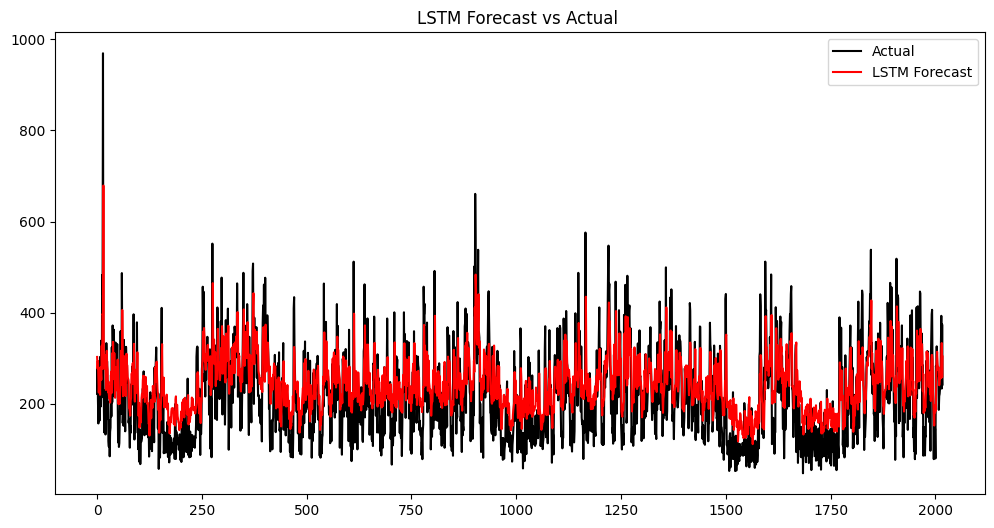

In [18]:


# ================================
# 1. CHỌN FEATURES CHO LSTM
# ================================
features = ['active_power', 'temp', 'humidity', 'pressure', 'speed',
            'ap_lag_1h', 'ap_lag_24h', 'ap_roll_24h']

df_lstm = df_hour[features].copy().dropna()

# ================================
# 2. SCALE DỮ LIỆU
# ================================
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_lstm)

# ================================
# 3. TẠO SEQUENCE (WINDOW)
# ================================
def create_sequences(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i, 0])   # cột 0 = active_power
    return np.array(X), np.array(y)

window_size = 24   # dùng 24 giờ gần nhất để dự báo giờ tiếp theo

X, y = create_sequences(scaled_data, window_size)

# ================================
# 4. TRAIN/TEST SPLIT
# ================================
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ================================
# 5. XÂY DỰNG MODEL LSTM
# ================================
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(window_size, X.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(32))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

# ================================
# 6. TRAIN MODEL
# ================================
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.1,
                    verbose=1)

# ================================
# 7. DỰ BÁO
# ================================
y_pred = model.predict(X_test)

# Inverse scale prediction
test_scaled = np.zeros((len(y_pred), scaled_data.shape[1]))
test_scaled[:, 0] = y_pred[:, 0]

y_pred_inv = scaler.inverse_transform(test_scaled)[:, 0]
y_test_inv = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1,1), np.zeros((len(y_test), scaled_data.shape[1]-1))], axis=1)
)[:, 0]

# ================================
# 8. ĐÁNH GIÁ
# ================================
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"LSTM → MAE={mae:.4f}, RMSE={rmse:.4f}")

# ================================
# 9. PLOT KẾT QUẢ
# ================================
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual', color='black')
plt.plot(y_pred_inv, label='LSTM Forecast', color='red')
plt.legend()
plt.title("LSTM Forecast vs Actual ")
plt.show()
